In [ ]:
import anndata
import torch
import stPlus
import os
import random
import warnings
import pickle
import sys

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr, plot_genes
from benchmark import SpaGE_impute, Tangram_impute
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
from spatialdm import plottings as sdmplt
from exp_spatialdm import spatialdm


warnings.filterwarnings('ignore')

seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
pre_datapath = "../../output/preprocessed_dataset/merfish_moffit.pkl"

In [2]:
with open(pre_datapath, 'rb') as infile:
    spa_adata, scrna_adata, raw_spatial_df, raw_scrna_df, raw_shared_gene = pickle.load(infile)
cls_key = 'leiden'
classes = scrna_adata.obs[cls_key]
ct_list = np.unique(classes)    

In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(raw_shared_gene)

pred_perf_uncertainty = []
test_gene_set = []
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpLR = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)

for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
    print(f"\n===== Fold {idx+1} =====\nNumber of train genes: {len(train_ind)}, Number of test genes: {len(test_ind)}")
    train_gene = raw_shared_gene[train_ind]
    test_gene  = raw_shared_gene[test_ind]
    
    test_spatial_df = raw_spatial_df[test_gene]
    spatial_df = raw_spatial_df[train_gene]
    scrna_df   = raw_scrna_df

    transImpRes = expTransImp(
                    df_ref=raw_scrna_df,
                    df_tgt=raw_spatial_df,
                    train_gene=train_gene,
                    test_gene=test_gene,
                    n_simulation=200,
                    signature_mode='cell',
                    mapping_mode='lowrank',
                    classes=classes,
                    n_epochs=2000,
                    seed=seed,
                    device=device
    )
    
    df_transImpLR[test_gene] = transImpRes[0]
    pred_perf_uncertainty.append(transImpRes[1])
    test_gene_set.append(test_gene)
    
    corr_transImpLR_res = calc_corr(raw_spatial_df, df_transImpLR, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_transImpLR_res)} (TransImpLR)')

    df_transImpCls[test_gene] = expTransImp(
            df_ref=raw_scrna_df,
            df_tgt=raw_spatial_df,
            train_gene=train_gene,
            test_gene=test_gene,
            ct_list=ct_list,
            classes=classes,
            n_epochs=2000,
            signature_mode='cluster',
            mapping_mode='full',
            seed=seed,
            device=device)

    corr_transImp_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_transImp_res)} (TransImpCls)')

    df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "/tmp/tmp_ug", verbose=False, random_seed=seed, device=device)
    corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_res_stplus)} (stPlus)')

    df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
    corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_res_spaGE)} (spaGE)')

    df_tangram_res[test_gene] = Tangram_impute(scrna_adata, spa_adata, train_gene, test_gene, device, cls_key)
    corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_res_tangram)} (Tangram)')


===== Fold 1 =====
Number of train genes: 122, Number of test genes: 31


[TransImp] Epoch: 2000/2000, loss: 0.419634, (IMP) 0.419634: 100%|██████████| 2000/2000 [00:20<00:00, 97.17it/s] 


fold 0, median cosine similarity: 0.5828927755355835 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 0.830040, (IMP) 0.830040: 100%|██████████| 2000/2000 [00:11<00:00, 169.30it/s]


fold 0, median cosine similarity: 0.6114228963851929 (TransImpCls)
fold 0, median cosine similarity: 0.6585298554905918 (stPlus)
fold 0, median cosine similarity: 0.6210087996035275 (spaGE)


INFO:root:122 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:122 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 122 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.428, KL reg: 0.085
Score: 0.657, KL reg: 0.001
Score: 0.659, KL reg: 0.001
Score: 0.659, KL reg: 0.001
Score: 0.659, KL reg: 0.001
Score: 0.659, KL reg: 0.001
Score: 0.659, KL reg: 0.001
Score: 0.660, KL reg: 0.001
Score: 0.660, KL reg: 0.001
Score: 0.660, KL reg: 0.001


INFO:root:Saving results..


fold 0, median cosine similarity: 0.6177811888730074 (Tangram)

===== Fold 2 =====
Number of train genes: 122, Number of test genes: 31


[TransImp] Epoch: 2000/2000, loss: 0.429671, (IMP) 0.429671: 100%|██████████| 2000/2000 [00:17<00:00, 117.29it/s]


fold 1, median cosine similarity: 0.5732978582382202 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 0.812098, (IMP) 0.812098: 100%|██████████| 2000/2000 [00:09<00:00, 208.80it/s]


fold 1, median cosine similarity: 0.5892459750175476 (TransImpCls)
fold 1, median cosine similarity: 0.561376506123374 (stPlus)
fold 1, median cosine similarity: 0.5456293221361099 (spaGE)


INFO:root:122 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:122 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 122 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.439, KL reg: 0.103
Score: 0.663, KL reg: 0.002
Score: 0.665, KL reg: 0.002
Score: 0.665, KL reg: 0.001
Score: 0.665, KL reg: 0.001
Score: 0.666, KL reg: 0.001
Score: 0.666, KL reg: 0.001
Score: 0.666, KL reg: 0.001
Score: 0.666, KL reg: 0.001
Score: 0.666, KL reg: 0.001


INFO:root:Saving results..


fold 1, median cosine similarity: 0.5857366828337828 (Tangram)

===== Fold 3 =====
Number of train genes: 122, Number of test genes: 31


[TransImp] Epoch: 2000/2000, loss: 0.358485, (IMP) 0.358485: 100%|██████████| 2000/2000 [00:16<00:00, 117.74it/s]


fold 2, median cosine similarity: 0.5732240080833435 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 0.712216, (IMP) 0.712216: 100%|██████████| 2000/2000 [00:09<00:00, 209.47it/s]


fold 2, median cosine similarity: 0.5515612959861755 (TransImpCls)
fold 2, median cosine similarity: 0.5900947019395422 (stPlus)
fold 2, median cosine similarity: 0.5650398696210214 (spaGE)


INFO:root:122 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:122 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 122 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.439, KL reg: 0.100
Score: 0.659, KL reg: 0.001
Score: 0.661, KL reg: 0.001
Score: 0.662, KL reg: 0.001
Score: 0.662, KL reg: 0.001
Score: 0.662, KL reg: 0.001
Score: 0.662, KL reg: 0.001
Score: 0.662, KL reg: 0.001
Score: 0.662, KL reg: 0.001
Score: 0.662, KL reg: 0.001


INFO:root:Saving results..


fold 2, median cosine similarity: 0.5373500892896502 (Tangram)

===== Fold 4 =====
Number of train genes: 123, Number of test genes: 30


[TransImp] Epoch: 2000/2000, loss: 0.431532, (IMP) 0.431532: 100%|██████████| 2000/2000 [00:17<00:00, 111.92it/s]


fold 3, median cosine similarity: 0.5080365538597107 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 0.818693, (IMP) 0.818693: 100%|██████████| 2000/2000 [00:09<00:00, 212.71it/s]


fold 3, median cosine similarity: 0.5227407813072205 (TransImpCls)
fold 3, median cosine similarity: 0.48496885172195225 (stPlus)
fold 3, median cosine similarity: 0.5158264414958122 (spaGE)


INFO:root:123 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:123 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 123 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.440, KL reg: 0.097
Score: 0.660, KL reg: 0.002
Score: 0.662, KL reg: 0.001
Score: 0.663, KL reg: 0.001
Score: 0.663, KL reg: 0.001
Score: 0.663, KL reg: 0.001
Score: 0.663, KL reg: 0.001
Score: 0.663, KL reg: 0.001
Score: 0.663, KL reg: 0.001
Score: 0.663, KL reg: 0.001


INFO:root:Saving results..


fold 3, median cosine similarity: 0.5112527404381269 (Tangram)

===== Fold 5 =====
Number of train genes: 123, Number of test genes: 30


[TransImp] Epoch: 2000/2000, loss: 0.415098, (IMP) 0.415098: 100%|██████████| 2000/2000 [00:17<00:00, 113.40it/s]


fold 4, median cosine similarity: 0.5263426303863525 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 0.776660, (IMP) 0.776660: 100%|██████████| 2000/2000 [00:09<00:00, 210.22it/s]


fold 4, median cosine similarity: 0.5350062251091003 (TransImpCls)
fold 4, median cosine similarity: 0.5053185700254199 (stPlus)
fold 4, median cosine similarity: 0.49421123992877325 (spaGE)


INFO:root:123 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:123 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 123 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.440, KL reg: 0.097
Score: 0.667, KL reg: 0.002
Score: 0.669, KL reg: 0.002
Score: 0.669, KL reg: 0.002
Score: 0.670, KL reg: 0.002
Score: 0.670, KL reg: 0.002
Score: 0.670, KL reg: 0.002
Score: 0.670, KL reg: 0.002
Score: 0.670, KL reg: 0.002
Score: 0.670, KL reg: 0.002


INFO:root:Saving results..


fold 4, median cosine similarity: 0.5264274081234379 (Tangram)


In [4]:
df_transImpLR.to_csv('../../output/merfish_moffit_TransImpLR.csv')
df_transImpCls.to_csv('../../output/merfish_moffit_TransImpCls.csv')
df_spaGE_res.to_csv('../../output/merfish_moffit_spaGE.csv')
df_stplus_res.to_csv('../../output/merfish_moffit_stPlus.csv')
df_tangram_res.to_csv('../../output/merfish_moffit_Tangram.csv')

In [5]:
corr_transImpLR_res = calc_corr(raw_spatial_df, df_transImpLR, raw_shared_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, raw_shared_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, raw_shared_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, raw_shared_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, raw_shared_gene)   

print(np.median(corr_transImpLR_res), "(TransImpLR)", 
      np.median(corr_transImpCls_res), "(TransImpCls)", 
      np.median(corr_res_stplus), "(stPlus)", 
      np.median(corr_res_spaGE), "(spaGE)",
      np.median(corr_res_tangram), "(Tangram)"
)

0.5618549585342407 (TransImpLR) 0.5603768229484558 (TransImpCls) 0.5499525657214135 (stPlus) 0.5456293221361099 (spaGE) 0.5528623900642877 (Tangram)


16
31
46
61
77
92
107
122
137
153


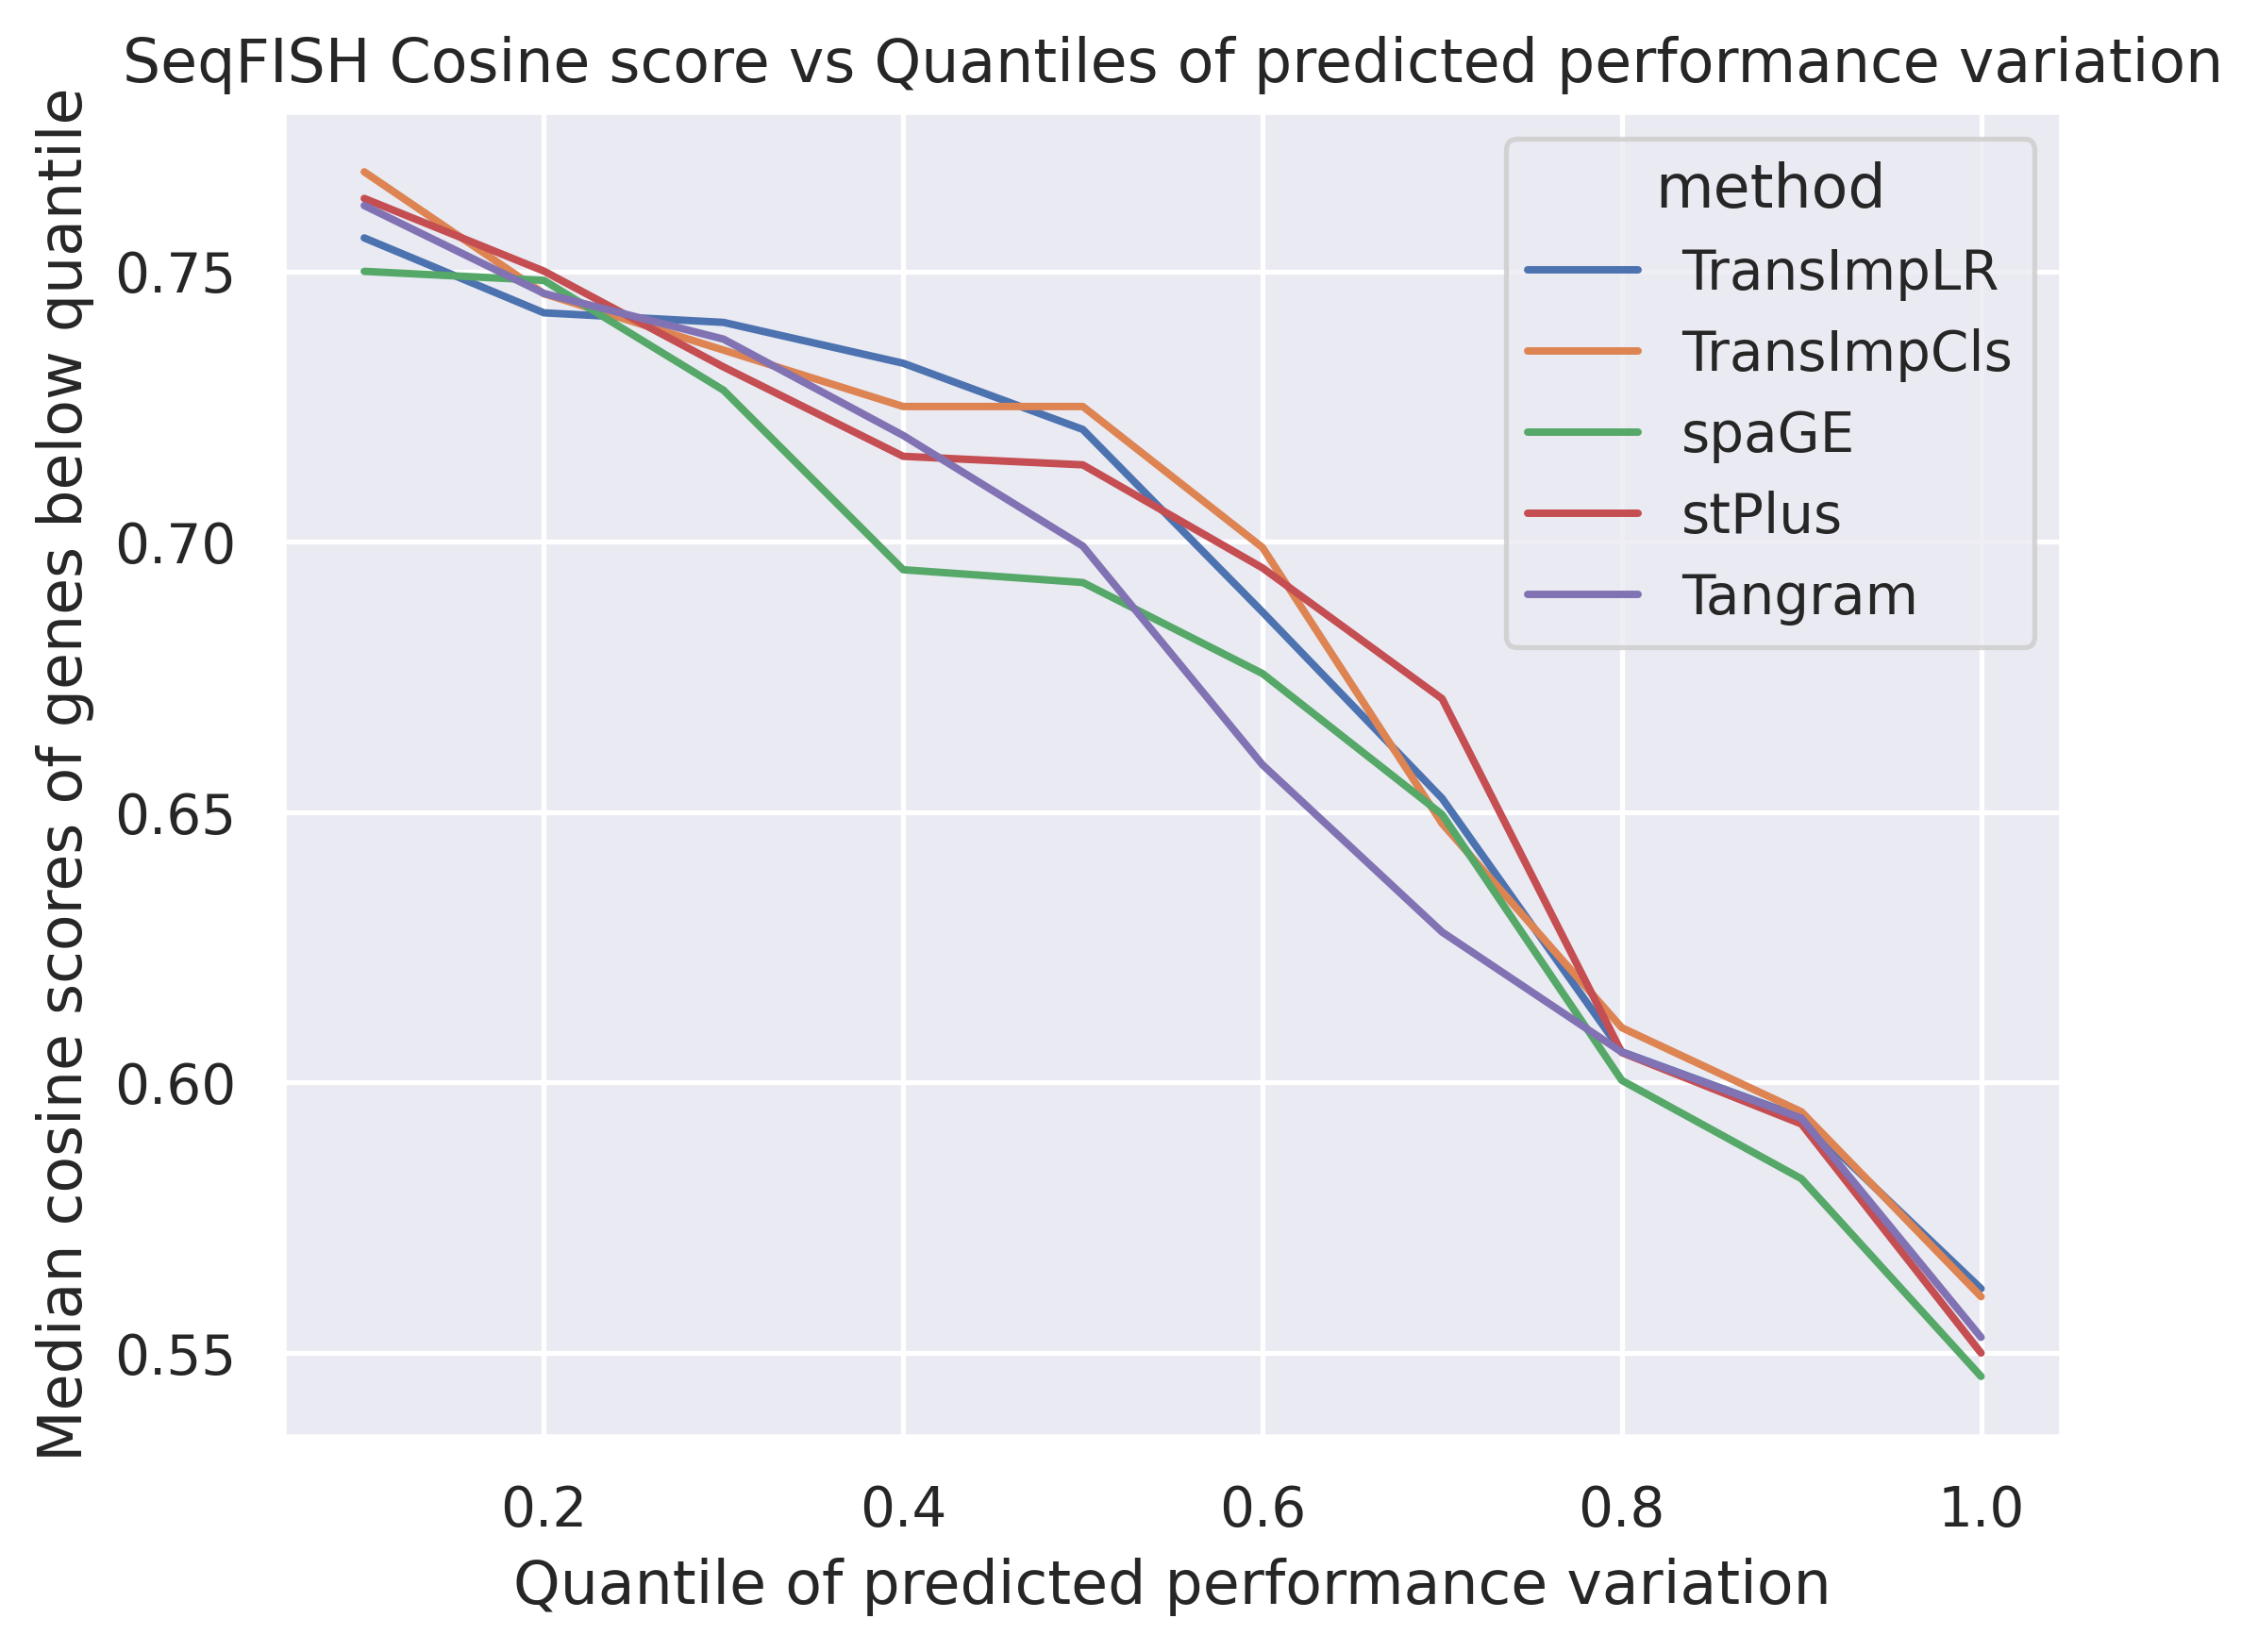

In [6]:
df_pred_uncertainty = pd.DataFrame(np.zeros((1, len(raw_shared_gene))), columns=raw_shared_gene)
for _test_genes, _sim_res in zip(test_gene_set, pred_perf_uncertainty):
    df_pred_uncertainty[_test_genes] = _sim_res

res = []
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for _quantile in quantiles:
    qt = np.quantile(df_pred_uncertainty.values, _quantile)
    sel = (df_pred_uncertainty <= qt).values.flatten()
    print(sel.sum())
    res.append({"cos_score":np.median(calc_corr(raw_spatial_df, df_transImpLR, raw_shared_gene[sel])), "method":"TransImpLR", "quantile":_quantile})
    res.append({"cos_score":np.median(calc_corr(raw_spatial_df, df_transImpCls, raw_shared_gene[sel])), "method":"TransImpCls", "quantile":_quantile})
    res.append({"cos_score":np.median(calc_corr(raw_spatial_df, df_spaGE_res, raw_shared_gene[sel])), "method":"spaGE", "quantile":_quantile})
    res.append({"cos_score":np.median(calc_corr(raw_spatial_df, df_stplus_res, raw_shared_gene[sel])), "method":"stPlus", "quantile":_quantile})
    res.append({"cos_score":np.median(calc_corr(raw_spatial_df, df_tangram_res, raw_shared_gene[sel])), "method":"Tangram", "quantile":_quantile})

sns.set_theme(rc={'figure.dpi': 380})
sns.lineplot(pd.DataFrame(res),x='quantile',y="cos_score", hue="method" ).set(xlabel ="Quantile of predicted performance variation", ylabel = "Median cosine scores of genes below quantile", title ='MERFISH Cosine score vs Quantiles of predicted performance variation');